In [149]:
import pandas as pd
import sys
import os
import json
import dash
from dash import html, dcc

from dash.dependencies import Output, Input
import plotly.tools as tls
import dash_cytoscape as cyto
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import networkx as nx
from cyjupyter import Cytoscape
from networkx.readwrite import cytoscape_data
import pdb
import pixiedust
#import the class 
file_dir = os.path.dirname('__file__')
sys.path.append(file_dir)
file_dir = os.path.dirname('__file__')
sys.path.append(file_dir)
from NetAnalysis import NetAnalysis
import gurobipy as gu
import time
import pickle

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# functions

In [61]:
def saveData(net, name):
    with open("pickled/{}.pickle".format(name), "wb") as f:
            pickle.dump(net,f)
    nx.write_gml(net.G ,"pickled/{}.csv".format(name))

## column Generation

In [246]:
def getDuals(constr):
    dual = {}
    slacks = {}
    for k,v in constr.items():
        dual[k] = v.PI
        slacks[k] = v.slack
    return dual, slacks
def getPrimalval(x):
    res = {}
    for k,v in x.items():
        res[k] = v.x
    return res
def edgeStatGetCapacityDict(es, labeldict):
    es.index = es.index.values
    es["edge"] = es.index.to_series().map(labeldict)
    return es.set_index("edge").maxPossibleFlow.to_dict()

In [766]:
def getInitial(self,k):
    it1 =  self.initialSolution(k)
    y_init = {e:1 if e in it1[2] else 0 for e in self.pathEdgeIncidence.columns}
    return y_init
def masterProblem(self, yHat):
    p = self.pathEdgeIncidence
    c= {}
    for e in self.G.edges:
        c[self.edgesLableDictReverse[e]] = self.G.edges[e]['capacity']
    # ce = {self.edgesLableDictReverse[e]:v for e,v in c.items() }
    q = self.pathCapacity
    I = self.pathEdgeIncidence.index

    m = gu.Model()
    f = m.addVars(I, name="f")
    y = m.addVars(p.columns)

    c_edgeCapacity = m.addConstrs((gu.quicksum(p.loc[i, e] * f[i] for i in p.index) 
                                   <= c[e] * (1 -yHat[e]) for e in p.columns), name='c3')
    m.setObjective(f.sum(), gu.GRB.MAXIMIZE)
    m.optimize()
    return getDuals(c_edgeCapacity), m.objVal
def subProblem(pi,c,k):
    msub = gu.Model("sub")
    a = msub.addVars(pi.keys(),vtype = gu.GRB.BINARY ,name  ="a")
    msub.addConstr(a.sum()==k)
    msub.setObjective(gu.quicksum(pi[e]*c[e]*a[e] for e in a.keys()) , gu.GRB.MAXIMIZE)
    msub.optimize()
    return getPrimalval(a)

In [768]:
from IPython.display import HTML
def colGen(self, k ):
    timeRecord = {}
    t = time.time()
    yHat1 = getInitial(self,k)
    t2 = time.time()
    timeRecord["init"] = {'t':t2-t, 'y' : [k for k,v in yHat1.items() if v==1] }
    c = {}
    for e in self.G.edges:
        c[self.edgesLableDictReverse[e]] = self.G.edges[e]['capacity']

    print("================================================== master problem")
    counter = 1
    t = time.time()
    (pi, sl) , obj= masterProblem(self,yHat1)
    print("\n\n\n\n======================sub problem============================ ")
    t2 = time.time()
    timeRecord["master{}".format(counter)] = {"t": t2-t , "obj":obj }
    yHat = subProblem(pi,c,k)
    t3 = time.time()
    timeRecord["sub{}".format(counter)] = {'t':t3-t2, 'y' : [k for k,v in yHat.items() if v==1] }
    print("\n\n\================================================== master problem")
    
    while ((yHat != yHat1) & (counter<10)):
        counter += 1
        t = time.time()
        (pi, sl), obj = masterProblem(self,yHat)
        t2 = time.time()
        timeRecord["master{}".format(counter)] = {"t": t2-t , "obj":obj }
        HTML("<text style=color:{}>{}</text>".format('blue', "\n\n====================sub problem============================== "))
        print("\n\n\n\n======================sub problem============================ ")
        yHat1 = yHat
        yHat = subProblem(pi,c,k)
        t3 = time.time()
        timeRecord["sub{}".format(counter)] = {'t':t3-t2, 'y' : [k for k,v in yHat.items() if v==1] }
        print("\n\n================================================== master problem")
#         pi, sl = masterProblem(self,yHat)
#         print("\n\n\n\n\x1b[31m\"============= counter={0}, same solution={1}\"\x1b[0m".format(counter,(yHat == yHat1)))
    return timeRecord

# (5,7)

In [756]:
from NetAnalysis import NetAnalysis
p1 = NetAnalysis.import_graph_from_excel("paper1", header=[0, 1], nodepos=True)

data contains two rows of header
['s', '1', '2', '3', 't']


In [759]:
p1.solvefork(1)
p1.solvefork(2)
p1.results

time  obj       sol
k method                         
1 MIP       0.0250  2.0      [e7]
  init      0.0020  2.0      [e7]
  MIP_init  0.0130  2.0      [e7]
2 MIP       0.0180 -0.0  [e2, e7]
  init      0.0030  0.0  [e7, e2]
  MIP_init      -1 -1.0        []

In [761]:
p1.colGen2(1)

================================================== master problem




======================sub problem============================ 


\================================================== master problem


{'init': {'t': 0.012993812561035156, 'y': ['e7']},
 'master1': {'t': 0.004996061325073242, 'obj': 2.0},
 'sub1': {'t': 0.002000093460083008, 'y': ['e7']}}

## plot RCI

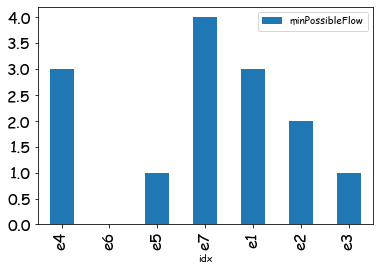

In [5]:
import matplotlib
# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Comic Sans MS"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
mpf = p1.edgeStatistics.minPossibleFlow.copy()
mpf = pd.DataFrame(mpf)
mpf["idx"]=mpf.index.to_series().map(p1.edgesLableDictReverse)
mpf =mpf.set_index("idx")
mpf.sort_index().plot.bar(fontsize = 16)

## column generation

In [721]:
res21cg = colGen(p1,2)

================================================== master problem
Optimize a model with 7 rows, 11 columns and 10 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 7 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00




======================sub problem============================ 
Optimize a model with 1 rows, 7 columns and 7 nonzeros
Variable types: 0 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 2.0000000
Presolve removed 1 rows and 7 colum

In [722]:
res21cg

{'init': {'t': 0.00999307632446289, 'y': ['e2', 'e7']},
 'master1': {'t': 0.0159909725189209, 'obj': -0.0},
 'sub1': {'t': 0.016988754272460938, 'y': ['e2', 'e7']}}

# (14, 32)

In [815]:
from NetAnalysis import NetAnalysis
n15 = NetAnalysis.generate_random([2,  12, 2])
saveData(n15,"N13E27")
n15.size

['s', '2', '3', '4', '5', '7', '9', '10', '12', '13', '14', '15', '16', 't']


(14, 32)

In [834]:
n15.solvefork(1)
n15.solvefork(2)
n15.solvefork(3)
n15.results

time   obj              sol
k method                                 
1 MIP       0.1996  17.0            [e32]
  init      0.0040  17.0            [e32]
  MIP_init  0.1749  17.0            [e32]
2 MIP       0.1539  10.0        [e5, e32]
  init      0.0060  12.0       [e32, e26]
  MIP_init  0.1799  10.0        [e5, e32]
3 MIP       0.2429   5.0  [e24, e27, e32]
  init      0.0060   9.0  [e32, e26, e30]
  MIP_init  0.2668   5.0  [e26, e27, e32]

In [836]:
n15.results.unstack()

time                    obj                             sol  \
method     MIP    init MIP_init   MIP  init MIP_init              MIP   
k                                                                       
1       0.1996  0.0040   0.1749  17.0  17.0     17.0            [e32]   
2       0.1539  0.0060   0.1799  10.0  12.0     10.0        [e5, e32]   
3       0.2429  0.0060   0.2668   5.0   9.0      5.0  [e24, e27, e32]   

                                          
method             init         MIP_init  
k                                         
1                 [e32]            [e32]  
2            [e32, e26]        [e5, e32]  
3       [e32, e26, e30]  [e26, e27, e32]

## column generation

In [840]:
n15.resultsGC[""]

,int,iny,m1t,m1obj,s1t,s1y,m2t,m2obj,s2t,s2y
2,0.015990,"['e26', 'e32']",0.123923,12.0,0.002999,"['e26', 'e32']",,,,
1,0.013991,['e32'],0.112930,17.0,0.001999,['e32'],,,,
3,0.013991,"['e26', 'e30', 'e32']",0.098940,9.0,0.003998,"['e5', 'e26', 'e32']",,,,


In [839]:
n15.colGen2(3)

================================================== master problem




======================sub problem============================ 


\================================================== master problem




======================sub problem============================ 


================================================== master problem
{'init': {'t': 0.013991117477416992, 'y': ['e26', 'e30', 'e32']}, 'master1': {'t': 0.09893989562988281, 'obj': 9.0}, 'sub1': {'t': 0.0039975643157958984, 'y': ['e5', 'e26', 'e32']}, 'master2': {'t': 0.09794187545776367, 'obj': 5.0}, 'sub2': {'t': 0.003996372222900391, 'y': ['e5', 'e26', 'e32']}}


{'init': {'t': 0.013991117477416992, 'y': ['e26', 'e30', 'e32']},
 'master1': {'t': 0.09893989562988281, 'obj': 9.0},
 'sub1': {'t': 0.0039975643157958984, 'y': ['e5', 'e26', 'e32']},
 'master2': {'t': 0.09794187545776367, 'obj': 5.0},
 'sub2': {'t': 0.003996372222900391, 'y': ['e5', 'e26', 'e32']}}

# (21,78)

In [818]:
from NetAnalysis import NetAnalysis
n21 = NetAnalysis.generate_random([2, 10, 10, 2])
n21.size

['s', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', 't']


(25, 89)

In [841]:
# for i in range(1,6):
#     n21.solvefork(i)
n21.results.unstack()

time                    obj                 \
method     MIP    init MIP_init   MIP  init MIP_init   
k                                                      
1       4.1913  0.0030   3.9088  21.0  21.0     21.0   
2       3.6645  0.0070   3.8154  14.0  16.0     14.0   
3       3.9975  0.0100   7.7511   9.0  11.0      9.0   
4       4.2209  0.0110   4.7403   4.0   4.0      4.0   
5       5.1970  0.0180   4.7786   2.0   2.0      2.0   
6       3.8417  0.0140       -1  -0.0   0.0     -1.0   

                              sol                              \
method                        MIP                        init   
k                                                               
1                            [e6]                       [e88]   
2                       [e5, e89]                   [e88, e1]   
3                  [e3, e88, e89]               [e88, e1, e3]   
4              [e1, e3, e88, e89]          [e88, e1, e3, e89]   
5              [e1, e3, e88, e89]      [e88, e1, e3, e89, e2]   
6       [e1, e2, e3, e4, e5, e89]  [e88, e1, e3, e89, e2, e4]   

                            
method            MIP_init  
k                           
1                    [e88]  
2                [e5, e89]  
3             [e1, e5, e6]  
4       [e1, e3, e88, e89]  
5       [e1, e3, e88, e89]  
6                       []

## Column Gen

In [826]:
for i in range(1,6):
    n21.colGen2(i)

================================================== master problem




======================sub problem============================ 


\================================================== master problem
{'init': {'t': 0.015990734100341797, 'y': ['e88']}, 'master1': {'t': 2.8594038486480713, 'obj': 21.0}, 'sub1': {'t': 0.002998828887939453, 'y': ['e88']}}
================================================== master problem




======================sub problem============================ 


\================================================== master problem




======================sub problem============================ 


================================================== master problem
{'init': {'t': 0.01499032974243164, 'y': ['e1', 'e88']}, 'master1': {'t': 2.855358839035034, 'obj': 16.0}, 'sub1': {'t': 0.0019986629486083984, 'y': ['e6', 'e88']}, 'master2': {'t': 2.858813762664795, 'obj': 14.0}, 'sub2': {'t': 0.002998828887939453, 'y': ['e6', 'e88']}}
===================================

In [845]:
n21.resultsGC

,int,iny,m1t,m1obj,s1t,s1y,m2t,m2obj,s2t,s2y
1,0.015991,['e88'],2.859404,21.0,0.002999,['e88'],,,,
2,0.014990,"['e1', 'e88']",2.855359,16.0,0.001999,"['e6', 'e88']",,,,
3,0.021986,"['e1', 'e3', 'e88']",3.073004,11.0,0.003997,"['e3', 'e6', 'e88']",,,,
4,0.023987,"['e1', 'e3', 'e88', 'e89']",2.754575,4.0,0.002998,"['e1', 'e3', 'e88', 'e89']",,,,
5,0.020987,"['e1', 'e2', 'e3', 'e88', 'e89']",3.054138,2.0,0.003000,"['e1', 'e3', 'e4', 'e88', 'e89']",,,,
6,0.030981,"['e1', 'e2', 'e3', 'e4', 'e88', 'e89']",2.737313,-0.0,0.002997,"['e1', 'e2', 'e3', 'e4', 'e88', 'e89']",,,,


# (32,166)

In [732]:
from NetAnalysis import NetAnalysis
n40 = NetAnalysis.generate_random([6, 15, 15, 6])
n40.size

(32, 166)

In [731]:
with open("large166.pickel",'wb') as f:
    pickle.dump(n40,f)

In [858]:
n40.results.unstack()

time                     obj                 \
method       MIP    init  MIP_init   MIP  init MIP_init   
k                                                         
2        87.8738  0.0110   85.5879  18.0  22.0     18.0   
3       113.4332  0.0230  114.0796  14.0  21.0     14.0   
1        89.0502  0.0070   81.2760  26.0  26.0     26.0   
4       137.6250  0.0260  165.0181  10.0  13.0     10.0   
5       149.3595  0.0310  128.3938   7.0  11.0      7.0   
6       230.6420  0.0300  296.3112   5.0  11.0      5.0   

                               sol                               \
method                         MIP                         init   
k                                                                 
2                       [e3, e166]                   [e166, e1]   
3                   [e1, e3, e166]               [e166, e1, e2]   
1                           [e166]                       [e166]   
4             [e1, e3, e161, e166]           [e166, e1, e2, e3]   
5       [e1, e3, e161, e163, e166]       [e166, e1, e2, e3, e4]   
6         [e1, e3, e5, e161, e166]  [e166, e1, e2, e3, e4, e95]   

                                      
method                      MIP_init  
k                                     
2                         [e3, e166]  
3                     [e1, e3, e166]  
1                             [e166]  
4               [e1, e3, e161, e166]  
5         [e1, e3, e161, e163, e166]  
6       [e1, e3, e4, e5, e161, e166]

## column generation

In [859]:
n40.resultsGC = {i: colGen(n40, i) for i in range(1,7)}

================================================== master problem
Optimize a model with 166 rows, 4472 columns and 35076 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+01]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 141 rows and 4416 columns
Presolve time: 0.02s
Presolved: 25 rows, 56 columns, 269 nonzeros

Ordering time: 0.00s

Barrier performed 0 iterations in 0.02 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 18 iterations and 0.03 seconds
Optimal objective  1.100000000e+01




======================sub problem============================ 
Optimize a model with 1 rows, 166 columns and 166 nonzeros
Variable types: 0 continuous, 166 integer (166 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds rang

In [862]:
n40.resultsGC

{2: {'init': {'t': 0.025983572006225586, 'y': ['e1', 'e166']},
  'master1': {'t': 61.59287071228027, 'obj': 22.0},
  'sub1': {'t': 0.03297996520996094, 'y': ['e3', 'e166']},
  'master2': {'t': 65.90098667144775, 'obj': 18.0},
  'sub2': {'t': 0.024982929229736328, 'y': ['e3', 'e166']}},
 3: {'init': {'t': 0.026983976364135742, 'y': ['e1', 'e166']},
  'master1': {'t': 70.0919873714447, 'obj': 22.0},
  'sub1': {'t': 0.05996298789978027, 'y': ['e3', 'e161', 'e166']},
  'master2': {'t': 68.9248743057251, 'obj': 14.0},
  'sub2': {'t': 0.06096196174621582, 'y': ['e3', 'e161', 'e166']}},
 4: {'init': {'t': 0.041974544525146484, 'y': ['e1', 'e166']},
  'master1': {'t': 65.0201678276062, 'obj': 22.0},
  'sub1': {'t': 0.06196260452270508, 'y': ['e1', 'e3', 'e161', 'e166']},
  'master2': {'t': 66.94494652748108, 'obj': 10.0},
  'sub2': {'t': 0.05296635627746582, 'y': ['e1', 'e3', 'e161', 'e166']}},
 5: {'init': {'t': 0.06296133995056152, 'y': ['e1', 'e2', 'e3', 'e4', 'e166']},
  'master1': {'t': 6

# (50)

In [ ]:
from NetAnalysis import NetAnalysis
n40 = NetAnalysis.generate_random([6, 25, 25, 6])

['s', '3', '4', '5', '6', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', 't']


#  (11,23)

In [753]:
from NetAnalysis import NetAnalysis
n18 = NetAnalysis.generate_random([2,  12, 2])
n18.size

(11, 23)

In [755]:
n18.colGen2(2)
n18.colGen2(3)
n18.colGen2(4)
n18.resultsGC

{2: {'init': {'t': 0.01898813247680664, 'y': ['e22', 'e23']},
  'master1': {'t': 0.05296635627746582, 'obj': 15.0},
  'sub1': {'t': 0.0039980411529541016, 'y': ['e22', 'e23']}},
 3: {'init': {'t': 0.016989707946777344, 'y': ['e3', 'e22', 'e23']},
  'master1': {'t': 0.040975093841552734, 'obj': 15.0},
  'sub1': {'t': 0.0049970149993896484, 'y': ['e19', 'e22', 'e23']},
  'master2': {'t': 0.03897356986999512, 'obj': 8.0},
  'sub2': {'t': 0.006996870040893555, 'y': ['e19', 'e22', 'e23']}},
 4: {'init': {'t': 0.018988847732543945, 'y': ['e3', 'e19', 'e22', 'e23']},
  'master1': {'t': 0.03997540473937988, 'obj': 8.0},
  'sub1': {'t': 0.0009989738464355469, 'y': ['e15', 'e19', 'e22', 'e23']},
  'master2': {'t': 0.04097437858581543, 'obj': 2.0},
  'sub2': {'t': 0.0019998550415039062, 'y': ['e15', 'e19', 'e22', 'e23']}}}

# a-2.4.2 very interesting

In [136]:
n1.edgesLableDict['e4'],n1.edgesLableDict['e2']

(('s', '6'), ('s', '4'))

In [130]:
rs = NetAnalysis.style_loader()

Cytoscape(data=cytoscape_data(n1.G),
                     layout_name='breadthfirst',
                     visual_style=rs[0]['style'])

True


Cytoscape(data={'data': [], 'directed': True, 'multigraph': False, 'elements': {'nodes': [{'data': {'pos': (0,…

In [132]:
n1.mm

time  obj            sol
inop method                              
2    bp      0.000000  4.0       [e4, e3]
     bb      0.015624  5.0      [e4, e27]
     bm      0.406239  3.0       (e2, e4)
3    bp      0.000000  2.0   [e4, e3, e2]
     bb      0.015622  2.0  [e4, e27, e9]
     bm      3.739119  2.0   (e1, e2, e4)

In [126]:
n1 = NetAnalysis.generate_random([2,  10, 2])
n1.solvefork(2)
n1.solvefork(3)
A1 , _ = getInitialColumn(n1,2)
dual1,primal1, slack1, obj1 =  masterProblemNew(A1,n1)
A211, objVal21 = subProblemNew(dual1,n1,2)
# df = pd.DataFrame({'dual':dual1,'slack':slack1, 'pattern1': A1, "pattern2":A211})
df = pd.DataFrame({'dual':dual1, 'pattern1': A1, "pattern2":A211})

df.loc[list(n1.mm.loc[2].sol.bm),"optimal"]=1
df.fillna(0,inplace=True)
df.loc[~(df==0).all(axis=1)]

['s', '1', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', 't']


,dual,pattern1,pattern2,optimal
e10,1.0,0,0.0,0.0
e11,1.0,0,0.0,0.0
e12,1.0,0,0.0,0.0
e13,1.0,0,0.0,0.0
e14,1.0,0,0.0,0.0
e16,1.0,0,0.0,0.0
e17,1.0,0,0.0,0.0
e18,1.0,0,0.0,0.0
e19,1.0,0,0.0,0.0
e2,0.0,0,0.0,1.0


## cyto

In [39]:
cytoscape_data(n1.G)['elements']['edges'][0]['data']

{'weight': 2, 'capacity': 10, 'source': 's', 'target': '5'}

In [313]:
rs = NetAnalysis.style_loader()
Cytoscape(data=cytoscape_data(n1.G),
                     layout_name='breadthfirst',
                     visual_style=rs[0]['style'])

True


Cytoscape(data={'data': [], 'directed': True, 'multigraph': False, 'elements': {'nodes': [{'data': {'pos': (0,…

In [118]:
n2.solvefork(2)

C:\Users\User\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.

C:\Users\User\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



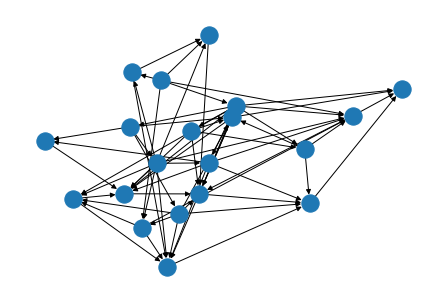

In [87]:
nx.draw(n1.G)

In [117]:
A2 , _ = getInitialColumn(n2,2)
dual2,primal2, slack2, obj2 =  masterProblemNew(A2,n2)
A212, objVal22 = subProblemNew(dual2,n2,2)
df = pd.DataFrame({'dual':dual2,'slack':slack2, 'pattern1': A2, "pattern2":A212})
df.loc[list(n2.mm.loc[2].sol.bm),"optimal"]=1
df.fillna(0,inplace=True)
df.loc[~(df==0).all(axis=1)]

,dual,slack,pattern1,pattern2,optimal
e10,1.0,0.0,0,0.0,0.0
e12,1.0,0.0,0,0.0,0.0
e13,1.0,0.0,0,0.0,0.0
e14,1.0,0.0,0,0.0,0.0
e15,1.0,0.0,0,0.0,0.0
e16,1.0,0.0,0,0.0,0.0
e17,1.0,0.0,0,0.0,0.0
e18,1.0,0.0,0,0.0,0.0
e19,1.0,0.0,0,0.0,0.0
e2,0.0,4.0,0,0.0,0.0


# A-2.3.2

In [314]:
from NetAnalysis import NetAnalysis as na
n2 = na.generate_random([2,3,2])


['s', '1', '5', '6', '7', 't']


# (17, 47)

In [208]:
with open("afterdefense.pickel",'wb') as f:
    pickle.dump(n15,f)

In [206]:
from NetAnalysis import NetAnalysis
n15 = NetAnalysis.generate_random([7,  12, 5])
n15.solvefork(2)
n15.results

['s', '7', '10', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', 't']


time   obj        sol
k method                               
2 Bilevel_enum  1.3612   9.0  (e4, e46)
  MIP           0.3628   9.0  [e4, e46]
  init          0.0030  10.0  [e46, e1]
  MIP_init      0.3688   9.0  [e4, e46]

In [221]:
self = n15
it1 =  self.initialSolution(2)


In [282]:
print("\x1b[31m\"red\"\x1b[0m")

"red"


In [301]:
colGen(n15,2)





================================================== master problem
Optimize a model with 47 rows, 116 columns and 308 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+00]
Presolve removed 26 rows and 85 columns
Presolve time: 0.02s
Presolved: 21 rows, 31 columns, 115 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3004000e+01   3.104650e+01   0.000000e+00      0s
      12    1.0000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 12 iterations and 0.03 seconds
Optimal objective  1.000000000e+01




======================sub problem============================ 
Optimize a model with 1 rows, 47 columns and 47 nonzeros
Variable types: 0 continuous, 47 integer (47 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+0

In [261]:
yHat = subProblem(pi,c,2)
pi, sl = masterProblem(n15,yHat)

Optimize a model with 1 rows, 47 columns and 47 nonzeros
Variable types: 0 continuous, 47 integer (47 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 6.0000000
Presolve removed 0 rows and 43 columns
Presolve time: 0.00s
Presolved: 1 rows, 4 columns, 4 nonzeros
Variable types: 0 continuous, 4 integer (3 binary)

Root relaxation: objective 1.300000e+01, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      13.0000000   13.00000  0.00%     -    0s

Explored 0 nodes (1 simplex iterations) in 0.03 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 13 6 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.300000000000e+01, best bound 1.300000000000e+

# (19, 58)

In [269]:
from NetAnalysis import NetAnalysis
n16 = NetAnalysis.generate_random([2, 10, 10, 2])

['s', '6', '8', '9', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', 't']


In [334]:
n16.G.edges

OutEdgeView([('s', '6'), ('s', '8'), ('s', '9'), ('s', '14'), ('s', '15'), ('s', '17'), ('s', '23'), ('s', '24'), ('6', '14'), ('6', '19'), ('6', '20'), ('6', '21'), ('6', '22'), ('6', 't'), ('8', '11'), ('8', '15'), ('8', '19'), ('8', '20'), ('8', '24'), ('9', '11'), ('9', '12'), ('9', '13'), ('9', '14'), ('9', '15'), ('9', '19'), ('9', '24'), ('11', '13'), ('11', '15'), ('11', 't'), ('12', '18'), ('12', '19'), ('12', '21'), ('12', '22'), ('12', '24'), ('13', '14'), ('13', '16'), ('13', '17'), ('13', '20'), ('13', '23'), ('13', '24'), ('14', '15'), ('14', '17'), ('14', '21'), ('14', 't'), ('15', '17'), ('15', '21'), ('15', '24'), ('16', '21'), ('17', '24'), ('17', 't'), ('18', '19'), ('19', '22'), ('20', 't'), ('21', 't'), ('22', 't'), ('23', '24'), ('23', 't'), ('24', 't')])

C:\Users\User\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.

C:\Users\User\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



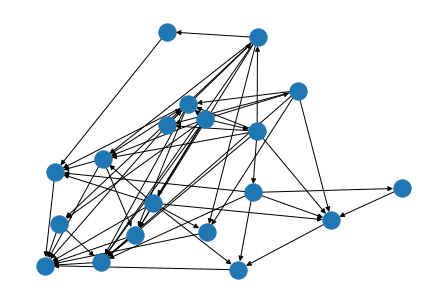

In [332]:
nx.draw(n16.G)

In [325]:
rs = NetAnalysis.style_loader()
Cytoscape(data=cytoscape_data(n16.G),
                     layout_name='breadthfirst',
                     visual_style=rs[0]['style'])

True


Cytoscape(data={'data': [], 'directed': True, 'multigraph': False, 'elements': {'nodes': [{'data': {'pos': (0,…

In [271]:
n16.solvefork(2)
n16.results

time   obj         sol
k method                                
2 Bilevel_enum  2.8882  21.0  (e44, e54)
  MIP           0.7375  21.0  [e44, e54]
  init          0.0040  23.0  [e44, e58]
  MIP_init      0.7186  21.0  [e44, e54]

In [287]:
colGen(n16,2)





================================================== master problem
Optimize a model with 58 rows, 169 columns and 523 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 9e+00]
Presolve removed 28 rows and 111 columns
Presolve time: 0.00s
Presolved: 30 rows, 58 columns, 240 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.3000000e+01   7.150950e+01   0.000000e+00      0s
      19    2.3000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 19 iterations and 0.02 seconds
Optimal objective  2.300000000e+01




======================sub problem============================ 
Optimize a model with 1 rows, 58 columns and 58 nonzeros
Variable types: 0 continuous, 58 integer (58 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+

# large problem

# large graph gen

In [440]:
import random
def randomGraphGenLarge():
    g = {}
    counter = 1
    i = 1
    g[counter ] = randomGraphGenForLargeNet(start=i)
def randomGraphGenForLargeNet(m=[2,3, 2], p=0.7, start = 1):
    g = nx.DiGraph()
    g.add_node(start, pos=(0, 0))
    newNode = start
    for i in m:
        for k in range(i):
            newNode += 1
            NetAnalysis.randomEdges(g, newNode, p)
    g1 = g.copy()
    for nod in g1.nodes:
        if len(list(g.successors(nod))) < 1 and nod != newNode:
            g.add_edge(nod, newNode, weight=random.randint(1, 10), capacity=random.randint(1, 10))
    return {"G":g, "s":start , "t":newNode}



C:\Users\User\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.

C:\Users\User\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



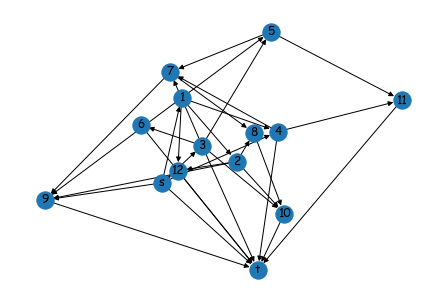

In [337]:
g,_ = NetAnalysis.randomGraphGen(m=[3,4,5])
nx.draw(g, with_labels = True)

In [492]:
graphs = {}
st = 1 
paths = {"s":[["s"]],"t":[["t"]]}
for n in g.nodes:
    if n not in ["s","t"]:
        graphs[n]=randomGraphGenForLargeNet(start=st)
        paths[n] = list(nx.all_simple_paths(graphs[n]["G"],graphs[n]["s"], graphs[n]["t"]))
        st=graphs[n]["t"] + 1


In [494]:
def getSequence(g):
    # g is the parent graph
    currents = set(g.successors('s'))
    sequene = ['s']

    while currents != set('t'):
        newItems = []
        for i in currents:
            iInSuccJ = False
            for j in currents:
                if i!= j and i in list(g.successors(j)):
                        iInSuccJ = True
                        break
            if not iInSuccJ:
                sequene.append(i)
                newItems.append(i)
        currents = currents.difference(newItems)
        for i in newItems:
            currents.update(set(g.successors(i)))
    sequene.append("t")
    return sequene


In [470]:
import itertools
def updatePaths(g,node):
    predPaths = []
    newPaths = []
    for p in g.predecessors(node):
        predPaths += paths2[p]
    
    for i in itertools.product(predPaths,paths[node]):
        newPaths.append(i[0]+i[1])
    return newPaths

def getSingleGraphPaths(g):
    graphs = {}
    st = 1 
    paths = {"s":[["s"]],"t":[["t"]]}
    for n in g.nodes:
        if n not in ["s","t"]:
            graphs[n]=randomGraphGenForLargeNet(start=st)
            paths[n] = list(nx.all_simple_paths(graphs[n]["G"],graphs[n]["s"], graphs[n]["t"]))
            st=graphs[n]["t"] + 1
    
    return graphs, paths

In [589]:
    
g2 = nx.compose_all( [gr['G'] for gr in graphs.values()])
for k in g.edges:
    if k[0] == "s" and k[1] != 't':
        g2.add_edge("s", graphs[k[1]]["s"] ,weight=random.randint(1, 10), capacity=random.randint(1, 10))
    elif k[1] == 't' and k[0] != "s":
        g2.add_edge( graphs[k[0]]["t"],"t" ,weight=random.randint(1, 10), capacity=random.randint(1, 10))
    elif k[0] != "s" and k[1] != 't':
        g2.add_edge(graphs[k[0]]["t"], graphs[k[1]]["s"],weight=random.randint(1, 10), capacity=random.randint(1, 10) )

In [531]:
def pathsGen(g):
    seq = getSequence(g)
    graphs,paths = getSingleGraphPaths()
    paths2 = {"s":[["s"]],"t":[["t"]]}
    for n in seq[1:]:
        paths2[n]=updatePaths(g,n)
    return paths2["t"]
paths = pathsGen(g)

In [611]:
aa  = NetAnalysisUsingPath("e167", g2,paths[1:])


In [612]:
aa.solvefork(2)

ValueError: Cannot mix scalar and tuple values in a tuplelist

In [389]:
rs = NetAnalysis.style_loader()
Cytoscape(data=cytoscape_data(g),
                     layout_name='breadthfirst',
                     visual_style=rs[0]['style'])

True


Cytoscape(data={'data': [], 'directed': True, 'multigraph': False, 'elements': {'nodes': [{'data': {'pos': (0,…